In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import pickle
import sys
from pathlib import Path

import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots

# torch.set_printoptions(precision=8, sci_mode=False, edgeitems=5)
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)

matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots

from tueplots import bundles, fontsizes, figsizes


from wbml import plot

### Locations

Read log files

In [38]:
folder = "results/07-27-20.32.17_seq-pvi-2c-2g-1000l-standardprior-80n-40b-0-02lr-2s-40m"

In [39]:
main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
preds_dir = os.path.join(main_dir, folder, "model")

In [41]:
file_name = 'eval_domain_preds.csv'
preds_file = os.path.join(preds_dir, file_name)

train_data = pd.read_csv(os.path.join(preds_dir, "training_data.csv"))
preds = pd.read_csv(preds_file)
preds

,x_eval,y_eval,pred_errors,pred_var,y_pred_mean,preds_0,preds_1,preds_2,preds_3,preds_4,...,preds_40,preds_41,preds_42,preds_43,preds_44,preds_45,preds_46,preds_47,preds_48,preds_49
0,-5.910248,-8.750907,-3.142321,2.547646,-5.608586,-4.172059,-6.021767,-8.025762,-5.601608,-6.614027,...,-5.663794,-3.502974,-4.922093,-2.633752,-4.495149,-4.854784,-7.707797,-5.042334,-5.900049,-5.078791
1,-5.790849,-8.417301,-2.987589,2.189503,-5.429712,-4.111983,-5.781456,-7.604597,-5.273844,-6.496849,...,-5.504269,-3.501012,-4.805611,-2.624752,-4.337112,-4.714683,-7.437421,-4.864522,-5.678379,-4.968263
2,-5.671451,-7.630617,-2.381457,1.863131,-5.249160,-4.051919,-5.541158,-7.132776,-4.943492,-6.384227,...,-5.344739,-3.499050,-4.689131,-2.615759,-4.179066,-4.576664,-7.167046,-4.686712,-5.456717,-4.864498
3,-5.552052,-7.145087,-2.085304,1.575610,-5.059783,-3.991849,-5.300847,-6.632124,-4.597108,-6.271598,...,-5.153363,-3.497089,-4.570087,-2.606763,-4.021034,-4.438639,-6.886268,-4.508897,-5.235049,-4.757507
4,-5.432652,-6.516577,-1.645019,1.327486,-4.871559,-3.931781,-5.060545,-6.131472,-4.284104,-6.158976,...,-4.954015,-3.495126,-4.439604,-2.597764,-3.878552,-4.300612,-6.596370,-4.331085,-5.013383,-4.650112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.432652,6.813651,1.868123,1.730894,4.945528,3.801286,4.486883,6.115004,6.059106,4.098465,...,6.239494,5.234697,4.485448,3.816921,4.952352,2.448972,7.004110,5.544440,4.026649,3.798684
96,5.552052,7.043599,1.946805,2.067602,5.096794,3.774571,4.823794,6.390849,6.253674,4.239129,...,6.450484,5.308032,4.609096,3.822373,5.130169,2.431718,7.327229,5.813011,4.036778,3.764972
97,5.671451,7.814335,2.564749,2.430219,5.249586,3.749217,5.160702,6.685525,6.448241,4.379790,...,6.661481,5.337504,4.732756,3.827821,5.309532,2.414761,7.650346,6.083288,4.046904,3.766642
98,5.790849,8.290645,2.889349,2.845772,5.401296,3.725551,5.492680,7.040968,6.642807,4.520454,...,6.872471,5.413741,4.856410,3.833269,5.487117,2.399555,7.973470,6.363144,4.057032,3.770042


In [42]:
if folder.split('/')[1].split('_')[1].split('-')[1] == 'pvi':
    q_type = 'GI'
else:
    q_type = 'MFVI'

data = preds
quartiles = np.quantile(preds.loc[:, preds.columns.str.startswith('preds_')], np.array((0.02275, 0.15865, 0.84135, 0.97725)), axis=1)
x_sorted, q0, q1, q2, q3 = zip(*sorted(zip(data['x_eval'], quartiles[0, :], quartiles[1, :], quartiles[2, :], quartiles[3, :])))

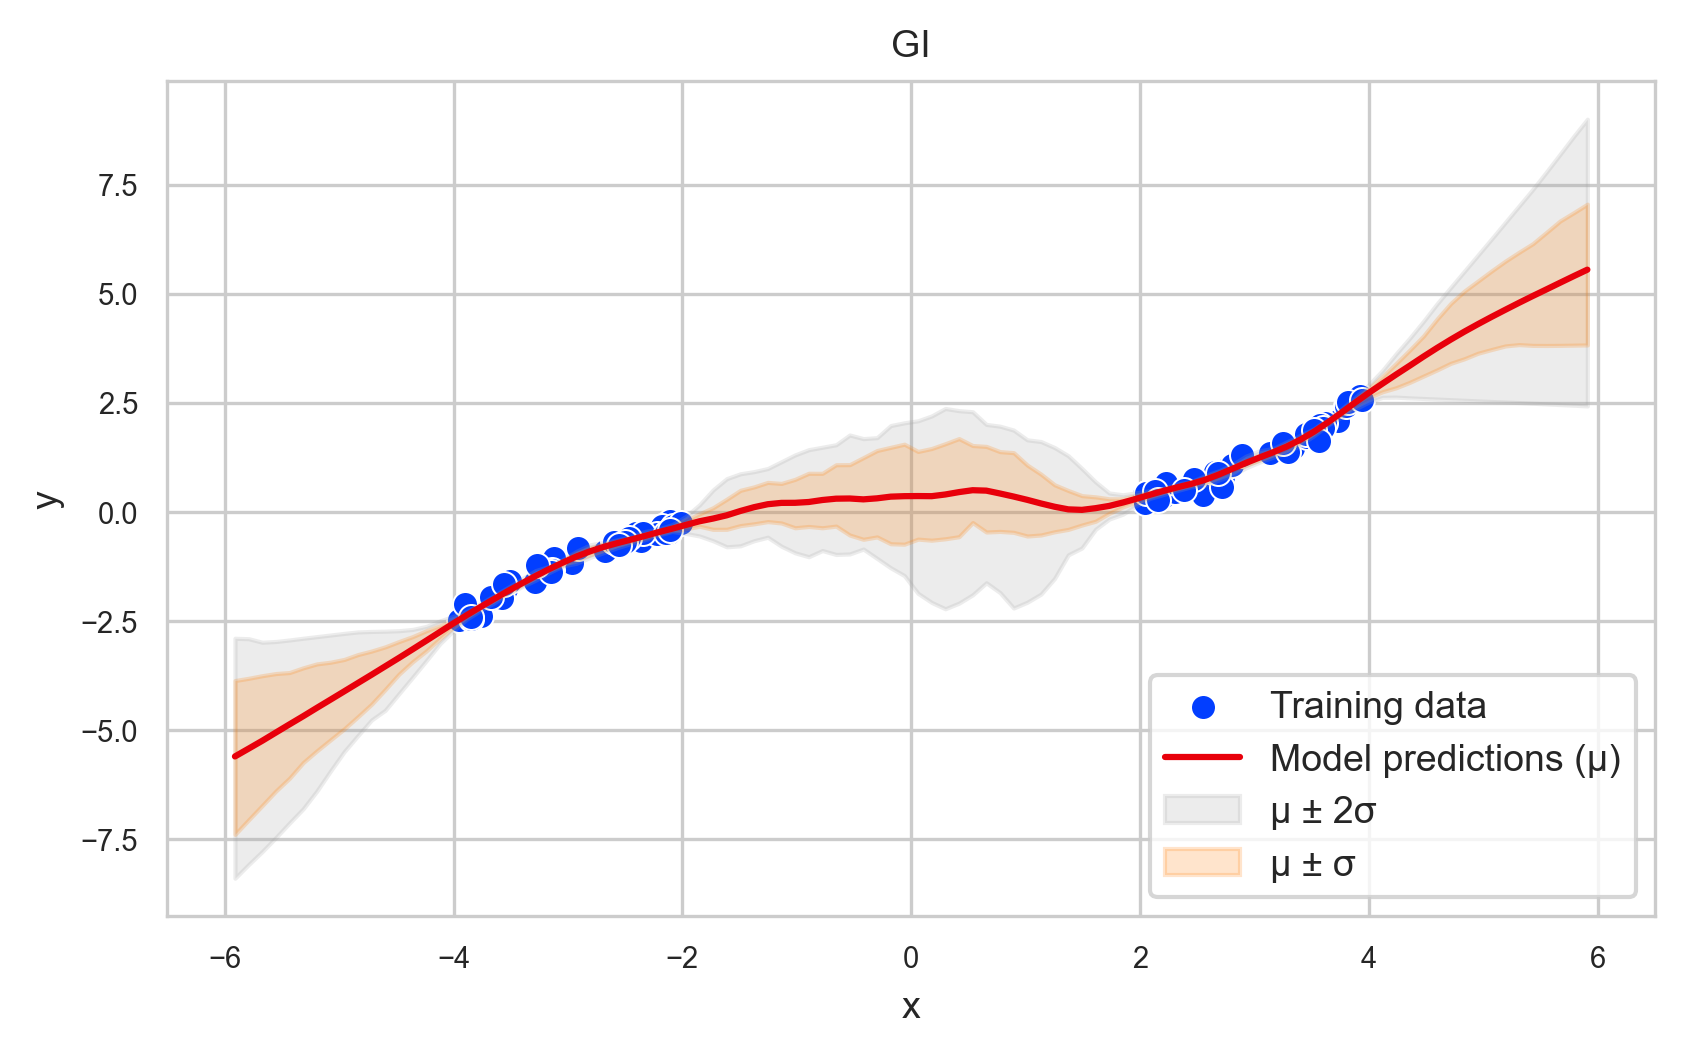

In [45]:
colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    x_metric = 'x_eval'
    y_metric = 'y_pred_mean'
    
    sns.scatterplot(data=train_data, x='x_tr', y='y_tr', ax=ax, label="Training data")
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, label="Model predictions (μ)", color=colors[3])
    
    x_sorted, q0, q1, q2, q3 = zip(*sorted(zip(data[x_metric], quartiles[0, :], quartiles[1, :], quartiles[2, :], quartiles[3, :])))
    ax.fill_between(x_sorted, q0, q3, color=colors[7], alpha=0.20, label="μ ± 2σ")
    ax.fill_between(x_sorted, q1, q2, color=colors[1], alpha=0.20, label="μ ± σ")
    
    ax.set_title(f'{q_type}')    
    ax.set_ylabel(' '.join(y_metric.split('_')[0]))
    ax.set_xlabel(' '.join(x_metric.split('_')[0]))
    ax.legend(loc="lower right", prop={"size": 9})

    # file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    # file_name += append_file_name
    # if save_plot: plt.savefig(file_name)
    plt.show()

    

Merge dataframes for plotting purposes.

# Plotting

test mll

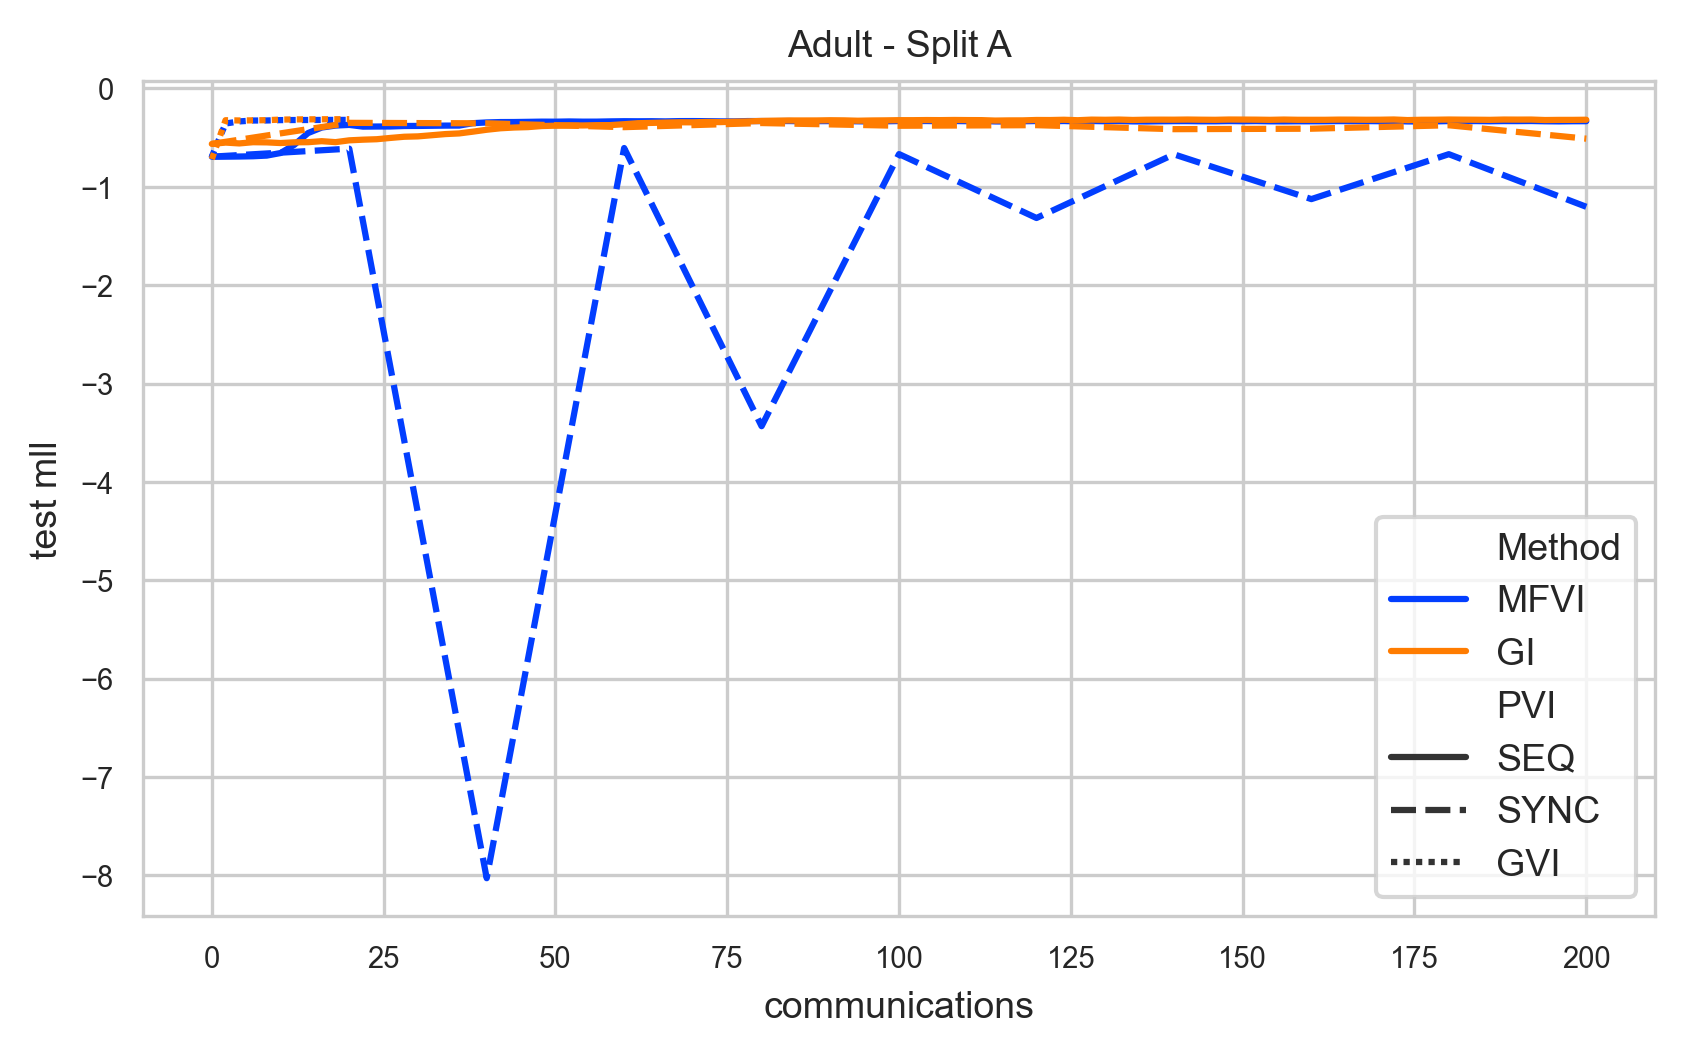

In [190]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    if omit_sync_mfvi:
        data = server.loc[(server[pvi_setting] != 'SYNC') | (server[variational_method] != 'MFVI')]
    else:
        data = server
    
    x_metric = 'communications'
    y_metric = 'test_mll'
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()

Accuracy

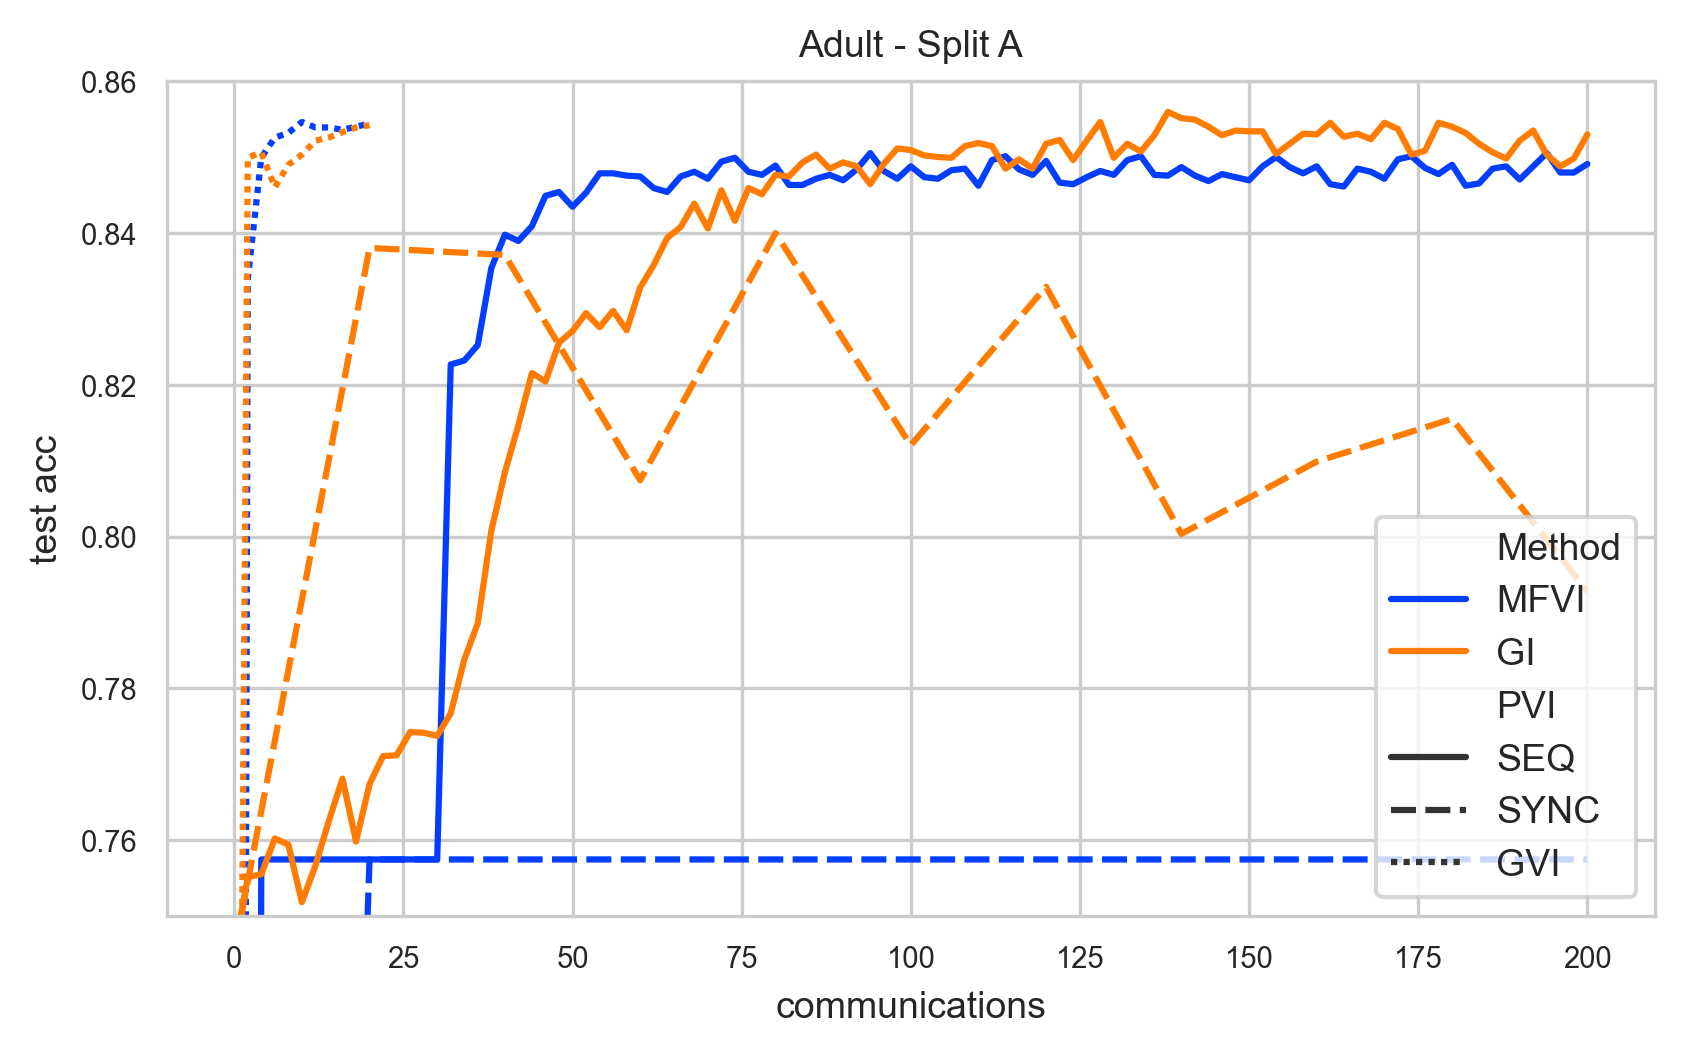

In [191]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    if omit_sync_mfvi:
        data = server.loc[(server[pvi_setting] != 'SYNC') | (server[variational_method] != 'MFVI')]
    else:
        data = server
    
    x_metric = 'communications'
    y_metric = 'test_acc'

    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Split {split}')
    if dataset.lower()=='bank':
        ylim=(0.85, 0.91)
    elif dataset.lower()=='adult':
        ylim=(0.75, 0.86)
        
    ax.set_ylim(ylim)
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})
    
    file_name = f"./{img_folder}/{split}_{dataset}_server_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"
    if save_plot: plt.savefig(file_name)
    plt.show()

In [145]:
client

,global_iteration,local_iteration,total_iteration,vfe,ll,kl,error,PVI,Method,Client
0,4,0,4000,-6.236976,-0.679725,20095.017578,0.132812,SEQ,MFVI,client4
1,4,49,4049,-6.161118,-0.678115,19826.537109,0.156250,SEQ,MFVI,client4
2,4,99,4099,-6.130808,-0.673799,19732.544922,0.093750,SEQ,MFVI,client4
3,4,149,4149,-6.118912,-0.673064,19692.185547,0.101562,SEQ,MFVI,client4
4,4,199,4199,-6.114376,-0.674430,19670.843750,0.140625,SEQ,MFVI,client4
...,...,...,...,...,...,...,...,...,...,...
8815,9,799,9799,-0.161379,-0.144709,602.917664,0.054688,GVI,GI,client0
8816,9,849,9849,-0.290775,-0.274702,581.320312,0.101562,GVI,GI,client0
8817,9,899,9899,-0.228825,-0.212784,580.175903,0.117188,GVI,GI,client0
8818,9,949,9949,-0.177203,-0.160438,606.353760,0.070312,GVI,GI,client0


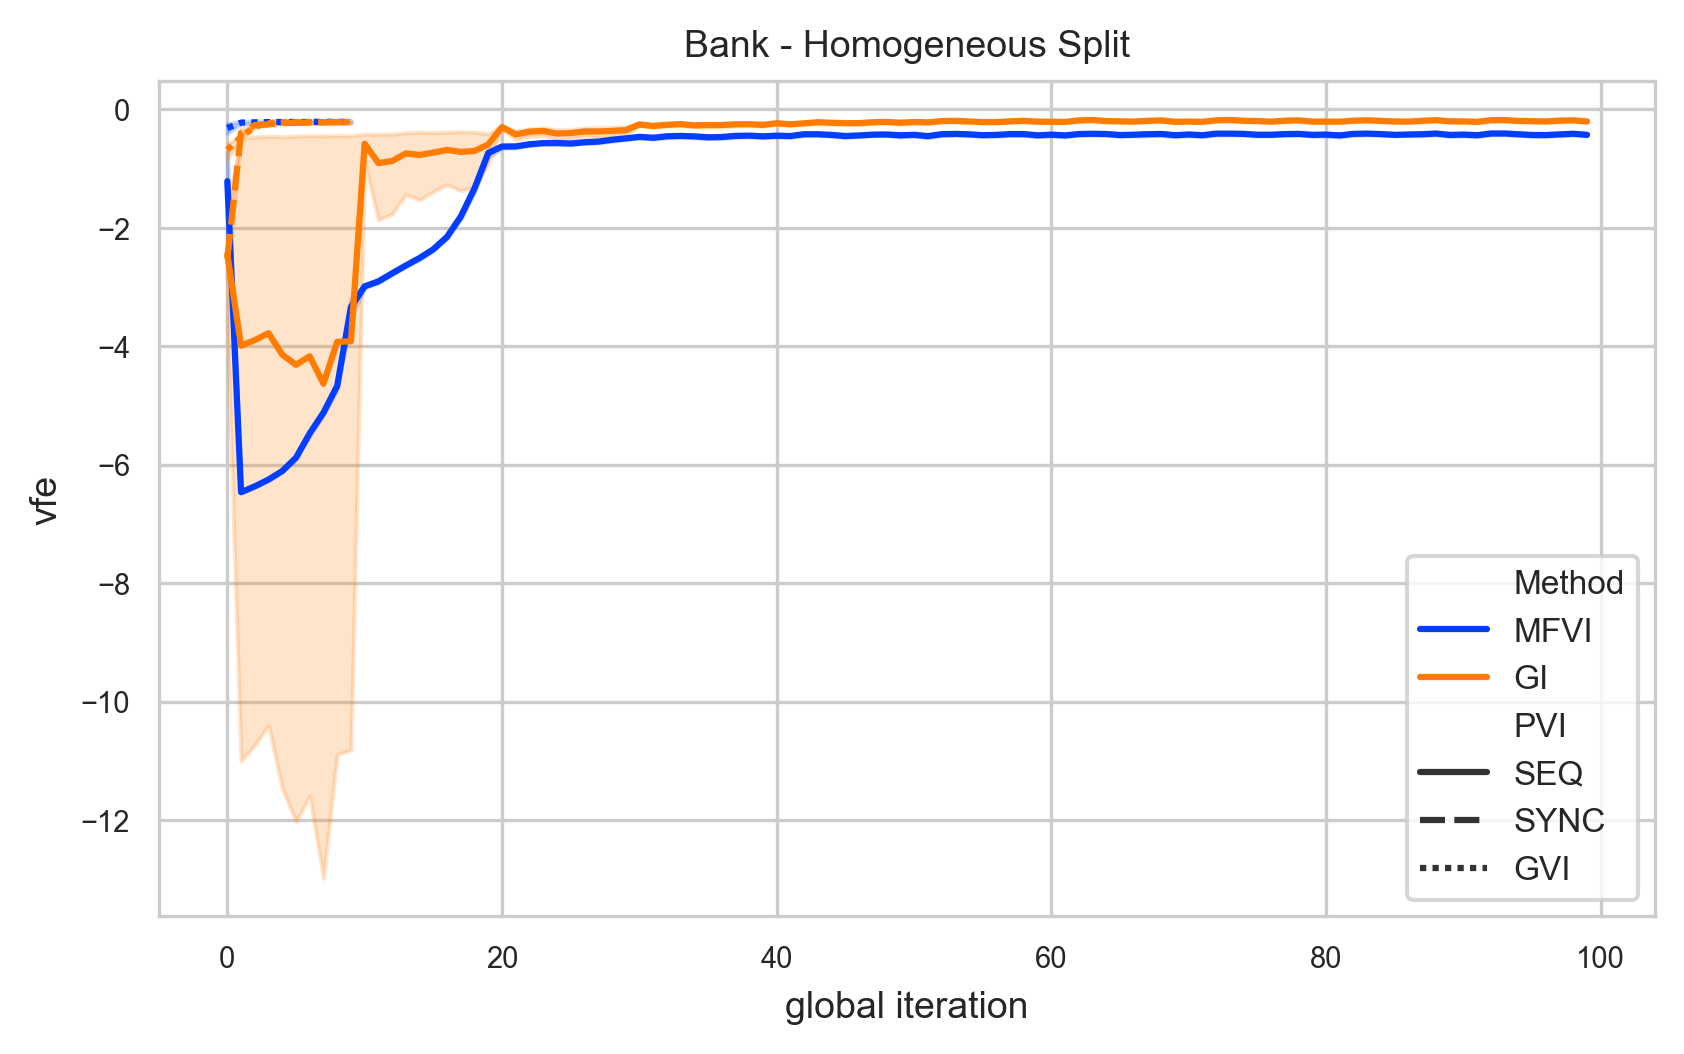

In [146]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    if omit_sync_mfvi:
        data = client.loc[(client[pvi_setting] != 'SYNC') | (client[variational_method] != 'MFVI')]
    else:
        data = client
    
    y_metric = "vfe"
    x_metric = "global_iteration"

    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_method, style=pvi_setting)
    
    ax.set_title(f'{dataset} - Homogeneous Split')
    # ax.set_ylim(-5, 0)
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 8})
    filename = f"./{img_folder}/{split}_{dataset}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi:
        filename += "_omit_sync_mfvi"
    if save_plot: plt.savefig(file_name)
    plt.show()
